In [ ]:
import pandas as pd
import json
from bertopic import BERTopic

e:\PythonProjects\DynamicTopicModeling\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('readovkanews.json', 'r', encoding='utf-8') as file:
    ndata = json.load(file)

In [4]:
df_titles = pd.DataFrame([{"title": item["title"], "time": item["time"]} for item in ndata])

comments = []
for i, item in enumerate(ndata):
    for comment in item["comments"]:
        comments.append({
            "title_number": i + 1,
            "comment": comment["comment"],
            "time": comment["time"]
        })

df_comments = pd.DataFrame(comments)

print("DataFrame с title и time:")
print(len(df_titles))

print("\nDataFrame с комментариями, временем и номером записи:")
print(len(df_comments))

DataFrame с title и time:
245

DataFrame с комментариями, временем и номером записи:
66171


In [5]:
documents = []

for _, row in df_titles.iterrows():
    documents.append(row["title"])

for _, row in df_comments.iterrows():
    documents.append(row["comment"])

In [6]:
import re

def clean_text(text):
    cleaned_text = re.sub(r"[^a-zA-Zа-яА-Я0-9\s]", "", text)
    cleaned_text = re.sub(r"\s+", " ", cleaned_text).strip()
    return cleaned_text

documents = [clean_text(doc) for doc in documents]

2. Логика алгоритма
    1. первоначальный запуск Бертопика на всём датасете
    2. группировка датасета по полученным темам
    3. каждая тема делиться на временные интвервалы и на каждом интвервале запускаем Бертопик
    (например: документы собраны с июня по август, одну тему делим на интервалы по неделе)
        вычисление на интервалах
        запускаем Бертопик на 1 интвервале, далее на 2 и сравниваем результат с первым, по ключевым словам в теме
            а. если разные (вычисляем по критерию), то получили новую тему
            б. если одинаковые, то тема остаётся.
        3 пункт можно повторить несколько раз, т.е. имеющийся интвервал разделить ещё раз
        в зависимости от начального интервала и каждого деления
    4. для группы интервалов по очереди запускаем суммаризацию на каждом под промежутке
    (здесь можно применить разные подходы. 
    например, применить суммаризацию к каждому интервалу, а потом на тех что одинаковая тема сделать обобщённую)
    5. для каждой выявленной темы в самом начале построить визуализацию как каждая тема менялась внутри, из какой темы следовала какая
    во времени.


1. Первичный запуск

In [7]:
topic_model = BERTopic(language="russian", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(documents)

2024-12-27 07:06:00,719 - BERTopic - Embedding - Transforming documents to embeddings.


Batches: 100%|██████████| 2076/2076 [05:36<00:00,  6.16it/s]
2024-12-27 07:11:41,018 - BERTopic - Embedding - Completed ✓
2024-12-27 07:11:41,019 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-12-27 07:12:23,735 - BERTopic - Dimensionality - Completed ✓
2024-12-27 07:12:23,737 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-12-27 07:38:58,225 - BERTopic - Cluster - Completed ✓
2024-12-27 07:38:58,241 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-12-27 07:38:59,399 - BERTopic - Representation - Completed ✓


In [8]:
topic_model.save("my_bertopic_model")

2024-12-27 07:39:53,458 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [74]:
freq = topic_model.get_topic_info(); freq.head(7)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,29911,-1_не_на_за_россии,"[не, на, за, россии, ты, что, по, как, это, бы]","[А какие ещ могут быть, А знаете ПОЧЕМУ такое ..."
1,0,896,0_учителя_учитель_учителей_школы,"[учителя, учитель, учителей, школы, школу, шко...",[Вообще то он первый ударил учителя рюкзаком н...
2,1,670,1_ему_он_его_него,"[ему, он, его, него, надеюсь, мистер, сказал, ...","[Ну это не ему решать, Это не должно жить Ему ..."
3,2,579,2_она_ей_ее_нее,"[она, ей, ее, нее, боня, полицию, думает, бони...","[ей то чего боятся она у себя в стране а ты, А..."
4,3,518,3_ислам_мусульмане_мусульман_приняла,"[ислам, мусульмане, мусульман, приняла, исламе...","[Ислам мирная религия, Это ислам у них традици..."
5,4,469,4_axy8243_неразборчиво_курс_веселится,"[axy8243, неразборчиво, курс, веселится, паппа...",[Дебильное русофобское недогосударство Был в э...
6,5,405,5_мигрантов_мигранты_мигрантам_мигрантами,"[мигрантов, мигранты, мигрантам, мигрантами, м...","[Больше мигрантов, Мигранты, от мигрантов]"


In [11]:
freq['Representative_Docs'].iloc[1]

['Вообще то он первый ударил учителя рюкзаком ни чего так нормально вс Возможно это не впервые происходит Может и не специально доводит но учитель в обычной школе не обучен тому как надо реагировать в таких ситуациях Нормальные дети доводят учителей так что поубивать их всех хочется а тут это орущее и дерущееся чудо Родителей нужно проверить что отдали такого ребнка в обычную школу его нужно дома обучать или в спецшколе Полностью на стороне учителя',
 'Учитель',
 'Вот такие теперь учителя']

In [12]:
freq['Count'].sum()

np.int64(66416)

2. Получение документ - тема - вероятность

In [13]:
doc_to_topic = topic_model.get_document_info(documents)

Проработка алгоритма на одной теме

In [14]:
doc_to_topic_1 = doc_to_topic[doc_to_topic['Topic'] == 0]

In [15]:
doc_to_topic_1

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
1348,а чем они вам мешают Работой на стройке тем бо...,0,0_учителя_учитель_учителей_школы,"[учителя, учитель, учителей, школы, школу, шко...",[Вообще то он первый ударил учителя рюкзаком н...,учителя - учитель - учителей - школы - школу -...,0.094944,False
1397,Это неверно У меня пятеро я учитель в провинци...,0,0_учителя_учитель_учителей_школы,"[учителя, учитель, учителей, школы, школу, шко...",[Вообще то он первый ударил учителя рюкзаком н...,учителя - учитель - учителей - школы - школу -...,0.293818,False
2658,Вот что значит равнодушие которое позволяет со...,0,0_учителя_учитель_учителей_школы,"[учителя, учитель, учителей, школы, школу, шко...",[Вообще то он первый ударил учителя рюкзаком н...,учителя - учитель - учителей - школы - школу -...,1.000000,False
2732,Мда более нелепую отмазку могли придумать имен...,0,0_учителя_учитель_учителей_школы,"[учителя, учитель, учителей, школы, школу, шко...",[Вообще то он первый ударил учителя рюкзаком н...,учителя - учитель - учителей - школы - школу -...,0.047853,False
2824,Можно на вменяемость проверять учителей врачей...,0,0_учителя_учитель_учителей_школы,"[учителя, учитель, учителей, школы, школу, шко...",[Вообще то он первый ударил учителя рюкзаком н...,учителя - учитель - учителей - школы - школу -...,0.122540,False
...,...,...,...,...,...,...,...,...
64012,Так уже лишилисьездим в столицу республики за ...,0,0_учителя_учитель_учителей_школы,"[учителя, учитель, учителей, школы, школу, шко...",[Вообще то он первый ударил учителя рюкзаком н...,учителя - учитель - учителей - школы - школу -...,0.068323,False
64233,Зачем вы утрируете На ряду с платными есть мно...,0,0_учителя_учитель_учителей_школы,"[учителя, учитель, учителей, школы, школу, шко...",[Вообще то он первый ударил учителя рюкзаком н...,учителя - учитель - учителей - школы - школу -...,0.116955,False
65116,Да почему необучаемыето Просто их никто не учи...,0,0_учителя_учитель_учителей_школы,"[учителя, учитель, учителей, школы, школу, шко...",[Вообще то он первый ударил учителя рюкзаком н...,учителя - учитель - учителей - школы - школу -...,0.055918,False
65887,Родители должны увлечь детей а не бросить их з...,0,0_учителя_учитель_учителей_школы,"[учителя, учитель, учителей, школы, школу, шко...",[Вообще то он первый ударил учителя рюкзаком н...,учителя - учитель - учителей - школы - школу -...,0.041730,False


In [16]:
documents_1 = []
count = 0
for _, row in df_titles.iterrows():
    documents_1.append([count, row["title"], row['time']])
    count += 1
# Добавляем комментарии как отдельные документы
for _, row in df_comments.iterrows():
    documents_1.append([count, row["comment"], row['time']])

import re

def clean_text(text):
    # Удаляем все символы, кроме букв (латиница, кириллица) и цифр
    cleaned_text = re.sub(r"[^a-zA-Zа-яА-Я0-9\s]", "", text)
    # Удаляем лишние пробелы
    cleaned_text = re.sub(r"\s+", " ", cleaned_text).strip()
    return cleaned_text

documents_1 = [[id, clean_text(doc), time] for id, doc, time in documents_1]

In [17]:
df_docs_1 = pd.DataFrame(documents_1, columns=['id', 'text', 'time'])

In [18]:
merged = doc_to_topic_1.merge(df_docs_1, how='left', left_on='Document', right_on='text')

In [19]:
merged.columns

Index(['Document', 'Topic', 'Name', 'Representation', 'Representative_Docs',
       'Top_n_words', 'Probability', 'Representative_document', 'id', 'text',
       'time'],
      dtype='object')

Убирём лишние колонки

In [20]:
res = merged[['id', 'text', 'time', 'Topic', 'Name','Representation', 'Top_n_words', 'Probability']]

In [21]:
res['time'] = pd.to_datetime(res['time'])

Разделим временной интервал на несколько промежутков

In [22]:
splited_documents = []

all_interval = res['time'].max() - res['time'].min()

In [23]:
all_interval

Timedelta('6 days 06:46:27')

Сделаем вывод что тема наблюдалась в течение 6 дней, разделим на 6 дней. 

в дальшейших реализациях будет введена обобщённая формула для разделения

In [24]:
res['day'] = res['time'].dt.day

In [25]:
res

,id,text,time,Topic,Name,Representation,Top_n_words,Probability,day
0,245,а чем они вам мешают Работой на стройке тем бо...,2024-12-26 15:12:45,0,0_учителя_учитель_учителей_школы,"[учителя, учитель, учителей, школы, школу, шко...",учителя - учитель - учителей - школы - школу -...,0.094944,26
1,245,Это неверно У меня пятеро я учитель в провинци...,2024-12-26 19:27:10,0,0_учителя_учитель_учителей_школы,"[учителя, учитель, учителей, школы, школу, шко...",учителя - учитель - учителей - школы - школу -...,0.293818,26
2,245,Вот что значит равнодушие которое позволяет со...,2024-12-26 14:45:15,0,0_учителя_учитель_учителей_школы,"[учителя, учитель, учителей, школы, школу, шко...",учителя - учитель - учителей - школы - школу -...,1.000000,26
3,245,Мда более нелепую отмазку могли придумать имен...,2024-12-26 13:51:12,0,0_учителя_учитель_учителей_школы,"[учителя, учитель, учителей, школы, школу, шко...",учителя - учитель - учителей - школы - школу -...,0.047853,26
4,245,Можно на вменяемость проверять учителей врачей...,2024-12-26 13:08:46,0,0_учителя_учитель_учителей_школы,"[учителя, учитель, учителей, школы, школу, шко...",учителя - учитель - учителей - школы - школу -...,0.122540,26
...,...,...,...,...,...,...,...,...,...
891,245,Так уже лишилисьездим в столицу республики за ...,2024-12-20 18:53:15,0,0_учителя_учитель_учителей_школы,"[учителя, учитель, учителей, школы, школу, шко...",учителя - учитель - учителей - школы - школу -...,0.068323,20
892,245,Зачем вы утрируете На ряду с платными есть мно...,2024-12-21 17:52:18,0,0_учителя_учитель_учителей_школы,"[учителя, учитель, учителей, школы, школу, шко...",учителя - учитель - учителей - школы - школу -...,0.116955,21
893,245,Да почему необучаемыето Просто их никто не учи...,2024-12-20 14:10:29,0,0_учителя_учитель_учителей_школы,"[учителя, учитель, учителей, школы, школу, шко...",учителя - учитель - учителей - школы - школу -...,0.055918,20
894,245,Родители должны увлечь детей а не бросить их з...,2024-12-21 06:43:43,0,0_учителя_учитель_учителей_школы,"[учителя, учитель, учителей, школы, школу, шко...",учителя - учитель - учителей - школы - школу -...,0.041730,21


In [51]:
import pymorphy3
from nltk.corpus import stopwords

morph = pymorphy3.MorphAnalyzer()

with open('stopwords-ru.txt', 'r', encoding='utf8') as f:
    words = [line.strip() for line in f.readlines()]

stop_words = set(words)

def clean_more(text: str):
    text = text.lower()
    words = text.split()
    lemmatized_words = [morph.parse(word)[0].normal_form for word in words if word not in stop_words]
    return " ".join(lemmatized_words)

In [52]:
res['clear_text'] = res['text'].apply(clean_more)

In [53]:
res

,id,text,time,Topic,Name,Representation,Top_n_words,Probability,day,clear_text
0,245,а чем они вам мешают Работой на стройке тем бо...,2024-12-26 15:12:45,0,0_учителя_учитель_учителей_школы,"[учителя, учитель, учителей, школы, школу, шко...",учителя - учитель - учителей - школы - школу -...,0.094944,26,мешать работа стройка многие получать образова...
1,245,Это неверно У меня пятеро я учитель в провинци...,2024-12-26 19:27:10,0,0_учителя_учитель_учителей_школы,"[учителя, учитель, учителей, школы, школу, шко...",учителя - учитель - учителей - школы - школу -...,0.293818,26,неверно пятеро учитель провинция трудно
2,245,Вот что значит равнодушие которое позволяет со...,2024-12-26 14:45:15,0,0_учителя_учитель_учителей_школы,"[учителя, учитель, учителей, школы, школу, шко...",учителя - учитель - учителей - школы - школу -...,1.000000,26,равнодушие который позволять совершать неправо...
3,245,Мда более нелепую отмазку могли придумать имен...,2024-12-26 13:51:12,0,0_учителя_учитель_учителей_школы,"[учителя, учитель, учителей, школы, школу, шко...",учителя - учитель - учителей - школы - школу -...,0.047853,26,мда нелепый отмазка мочь придумать управление ...
4,245,Можно на вменяемость проверять учителей врачей...,2024-12-26 13:08:46,0,0_учителя_учитель_учителей_школы,"[учителя, учитель, учителей, школы, школу, шко...",учителя - учитель - учителей - школы - школу -...,0.122540,26,вменяемость проверять учитель врач полиция
...,...,...,...,...,...,...,...,...,...,...
891,245,Так уже лишилисьездим в столицу республики за ...,2024-12-20 18:53:15,0,0_учителя_учитель_учителей_школы,"[учителя, учитель, учителей, школы, школу, шко...",учителя - учитель - учителей - школы - школу -...,0.068323,20,лишилисьездить столица республика 150 км ребён...
892,245,Зачем вы утрируете На ряду с платными есть мно...,2024-12-21 17:52:18,0,0_учителя_учитель_учителей_школы,"[учителя, учитель, учителей, школы, школу, шко...",учителя - учитель - учителей - школы - школу -...,0.116955,21,утрировать ряд платный бесплатный секция кружо...
893,245,Да почему необучаемыето Просто их никто не учи...,2024-12-20 14:10:29,0,0_учителя_учитель_учителей_школы,"[учителя, учитель, учителей, школы, школу, шко...",учителя - учитель - учителей - школы - школу -...,0.055918,20,необучаемыеть учить верный учить неэффективно
894,245,Родители должны увлечь детей а не бросить их з...,2024-12-21 06:43:43,0,0_учителя_учитель_учителей_школы,"[учителя, учитель, учителей, школы, школу, шко...",учителя - учитель - учителей - школы - школу -...,0.041730,21,родитель должный увлечь ребёнок бросить занима...


In [117]:
res = res[res.day != 20]

Повторно запускаем модель на 6 днях

In [118]:
all_models = []
all_docs_with_topic = []

for day in res.day.unique():
    print(day)
    cur_doc = res[res.day == day]['clear_text']

    cur_topic_model = BERTopic(language="russian", calculate_probabilities=True, verbose=True)
    cur_topics, cur_probs = cur_topic_model.fit_transform(cur_doc)

    all_models.append([day, cur_topic_model]) # сохраним модель

    cur_doc_with_topic = cur_topic_model.get_document_info(cur_doc)
    all_docs_with_topic.append([day, cur_doc_with_topic]) 

2024-12-27 08:50:43,765 - BERTopic - Embedding - Transforming documents to embeddings.


26


Batches: 100%|██████████| 2/2 [00:00<00:00,  3.91it/s]
2024-12-27 08:50:46,802 - BERTopic - Embedding - Completed ✓
2024-12-27 08:50:46,803 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-12-27 08:50:48,411 - BERTopic - Dimensionality - Completed ✓
2024-12-27 08:50:48,412 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-12-27 08:50:48,417 - BERTopic - Cluster - Completed ✓
2024-12-27 08:50:48,420 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-12-27 08:50:48,429 - BERTopic - Representation - Completed ✓
2024-12-27 08:50:48,442 - BERTopic - Embedding - Transforming documents to embeddings.


25


Batches: 100%|██████████| 4/4 [00:00<00:00,  5.18it/s]
2024-12-27 08:50:51,554 - BERTopic - Embedding - Completed ✓
2024-12-27 08:50:51,554 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-12-27 08:50:52,973 - BERTopic - Dimensionality - Completed ✓
2024-12-27 08:50:52,974 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-12-27 08:50:52,985 - BERTopic - Cluster - Completed ✓
2024-12-27 08:50:52,988 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-12-27 08:50:52,999 - BERTopic - Representation - Completed ✓
2024-12-27 08:50:53,021 - BERTopic - Embedding - Transforming documents to embeddings.


24


Batches: 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]
2024-12-27 08:50:56,018 - BERTopic - Embedding - Completed ✓
2024-12-27 08:50:56,018 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-12-27 08:51:01,537 - BERTopic - Dimensionality - Completed ✓
2024-12-27 08:51:01,538 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-12-27 08:51:01,542 - BERTopic - Cluster - Completed ✓
2024-12-27 08:51:01,545 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-12-27 08:51:01,555 - BERTopic - Representation - Completed ✓
2024-12-27 08:51:01,572 - BERTopic - Embedding - Transforming documents to embeddings.


23


Batches: 100%|██████████| 20/20 [00:03<00:00,  5.28it/s]
2024-12-27 08:51:07,534 - BERTopic - Embedding - Completed ✓
2024-12-27 08:51:07,534 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-12-27 08:51:09,720 - BERTopic - Dimensionality - Completed ✓
2024-12-27 08:51:09,722 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-12-27 08:51:09,777 - BERTopic - Cluster - Completed ✓
2024-12-27 08:51:09,780 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-12-27 08:51:09,821 - BERTopic - Representation - Completed ✓
2024-12-27 08:51:09,860 - BERTopic - Embedding - Transforming documents to embeddings.


22


Batches: 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]
2024-12-27 08:51:12,309 - BERTopic - Embedding - Completed ✓
2024-12-27 08:51:12,310 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-12-27 08:51:13,983 - BERTopic - Dimensionality - Completed ✓
2024-12-27 08:51:13,985 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-12-27 08:51:13,988 - BERTopic - Cluster - Completed ✓
2024-12-27 08:51:13,991 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-12-27 08:51:13,997 - BERTopic - Representation - Completed ✓
2024-12-27 08:51:14,008 - BERTopic - Embedding - Transforming documents to embeddings.


21


Batches: 100%|██████████| 1/1 [00:00<00:00,  5.63it/s]
2024-12-27 08:51:16,387 - BERTopic - Embedding - Completed ✓
2024-12-27 08:51:16,387 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-12-27 08:51:17,678 - BERTopic - Dimensionality - Completed ✓
2024-12-27 08:51:17,679 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-12-27 08:51:17,682 - BERTopic - Cluster - Completed ✓
2024-12-27 08:51:17,685 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-12-27 08:51:17,692 - BERTopic - Representation - Completed ✓


In [119]:
all_docs_with_topic.reverse()

In [121]:
events = {}

for day, data in all_docs_with_topic:
    list_top_words = data['Top_n_words'].unique().tolist()
    new_top_words = []
    for top_words in list_top_words:
        top_4 = '|'.join(top_words.split(' - ')[:4])
        new_top_words.append(top_4)
    events[day] = new_top_words
    print(day)
    print(new_top_words)


21
['учебник|школа|бесплатно|занятие']
22
['учитель|школа|начать|инструктор']
23
['учитель|приступ|виноватый|ещ', 'ребёнок|школа|такой|родитель', 'урок|учитель|сидеть|школа', 'учитель|бедный|остаться|педагог', 'ребёнок|учитель|школа|такой', 'диагноз|знать|ребёнок|должный', 'видео|видно|ударить|ребнок', 'закрыть|школа|вс|ребёнок', 'ребёнок|школа|образование|инклюзивный', 'рюкзак|ударить|учитель|ученик']
24
['ребёнок|школа|учитель|такой']
25
['учитель|ребёнок|школа|история', 'учитель|школа|ученик|директор', 'учитель|педагог|квалификация|судить']
26
['учитель|школа|ребёнок|сторона']


### Визуализация 

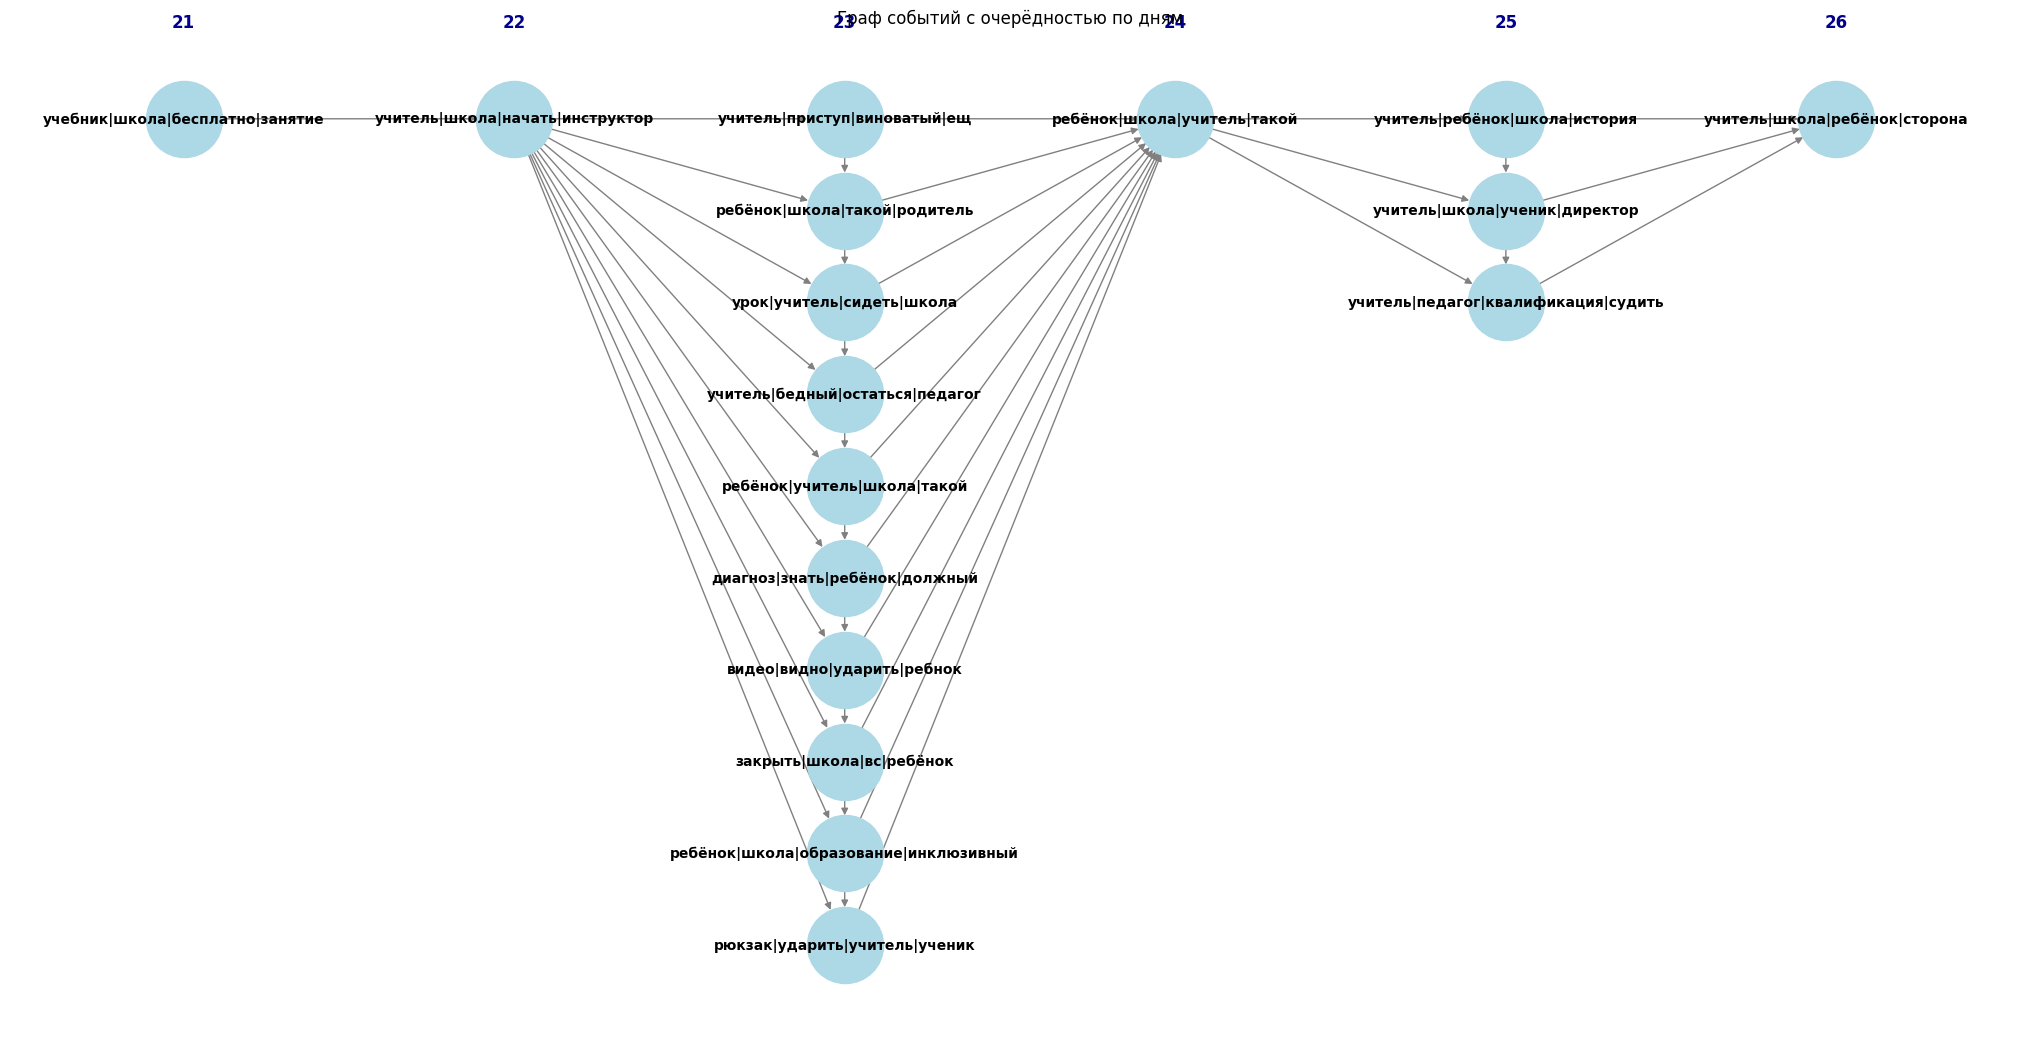

In [122]:
import networkx as nx
import matplotlib.pyplot as plt


G = nx.DiGraph()

pos = {}
x = 0

previous_day_events = []

for day, day_events in events.items():
    y = 0

    for event in day_events:
        G.add_node(event, day=day)
        pos[event] = (x, -y)
        y += 1
    
    for i in range(len(day_events) - 1):
        G.add_edge(day_events[i], day_events[i + 1])
    
    for prev_event in previous_day_events:
        for curr_event in day_events:
            G.add_edge(prev_event, curr_event)
    
    previous_day_events = day_events
    x += 1

plt.figure(figsize=(20, 10))
nx.draw(
    G, pos, with_labels=True, node_color='lightblue', node_size=3000,
    font_size=10, font_color='black', font_weight='bold', edge_color='gray', arrows=True
)

for day_idx, (day, day_events) in enumerate(events.items()):
    plt.text(day_idx, 1, day, fontsize=12, fontweight='bold', ha='center', color='darkblue')

plt.title("Граф событий с очерёдностью по дням")
plt.show()
